In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
import optuna

d:\OneDrive - Hemas Holdings\Desktop\Model\ENV\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# PP

## DataSet

In [2]:
Data = pd.read_excel("Company Data.xlsx")
Data.to_csv("Company Data.csv", index=False)

In [3]:
Data = pd.read_csv("Company Data.csv")
Data.head()

,Month,Year,Month_Number,ItemCode,Secondary_Sales_Qty,Free_Qty,Primary_Sales_Qty,Available_Primary_Inventory_Qty,Blocked_Stock_Qty,Inspection_Stock_Qty,Total_Primary_Inventory_Qty,Distributor_Inventory_Qty,Bonus_Flag,Supply_Constraint_Flag,Distributor_Buffer_Flag,Time_Index
0,2021-03,2021,3,600153,25.0,0.0,25.0,27.0,0.0,0.0,27.0,0,0,0,0,202103
1,2021-03,2021,3,600172,7.0,0.0,7.0,1.0,0.0,0.0,1.0,0,0,0,0,202103
2,2021-03,2021,3,600232,2.0,0.0,2.0,9.0,0.0,0.0,9.0,0,0,0,0,202103
3,2021-03,2021,3,600234,11.0,0.0,11.0,70.0,0.0,0.0,70.0,0,0,0,0,202103
4,2021-03,2021,3,600235,29.0,0.0,29.0,33.0,0.0,0.0,33.0,0,0,0,0,202103


In [4]:
Data.info()

<class 'pandas.DataFrame'>
RangeIndex: 149940 entries, 0 to 149939
Data columns (total 16 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   Month                            149940 non-null  str    
 1   Year                             149940 non-null  int64  
 2   Month_Number                     149940 non-null  int64  
 3   ItemCode                         149940 non-null  int64  
 4   Secondary_Sales_Qty              149940 non-null  float64
 5   Free_Qty                         149940 non-null  float64
 6   Primary_Sales_Qty                149940 non-null  float64
 7   Available_Primary_Inventory_Qty  149940 non-null  float64
 8   Blocked_Stock_Qty                149940 non-null  float64
 9   Inspection_Stock_Qty             149940 non-null  float64
 10  Total_Primary_Inventory_Qty      149940 non-null  float64
 11  Distributor_Inventory_Qty        149940 non-null  int64  
 12  Bonus_Flag   

In [5]:
Data.count()

Month                              149940
Year                               149940
Month_Number                       149940
ItemCode                           149940
Secondary_Sales_Qty                149940
Free_Qty                           149940
Primary_Sales_Qty                  149940
Available_Primary_Inventory_Qty    149940
Blocked_Stock_Qty                  149940
Inspection_Stock_Qty               149940
Total_Primary_Inventory_Qty        149940
Distributor_Inventory_Qty          149940
Bonus_Flag                         149940
Supply_Constraint_Flag             149940
Distributor_Buffer_Flag            149940
Time_Index                         149940
dtype: int64

In [6]:
# Check Duplicates
dup_count = Data.duplicated().sum()
print(dup_count)

0


In [7]:
# Check Nulls
null_count = Data.isnull().sum()
print(null_count)

Month                              0
Year                               0
Month_Number                       0
ItemCode                           0
Secondary_Sales_Qty                0
Free_Qty                           0
Primary_Sales_Qty                  0
Available_Primary_Inventory_Qty    0
Blocked_Stock_Qty                  0
Inspection_Stock_Qty               0
Total_Primary_Inventory_Qty        0
Distributor_Inventory_Qty          0
Bonus_Flag                         0
Supply_Constraint_Flag             0
Distributor_Buffer_Flag            0
Time_Index                         0
dtype: int64


## Demand Signal Engineering

In [8]:
Data = Data.sort_values(["ItemCode", "Year", "Month_Number"])

# Rolling 3 month average
Data["Rolling3M_Avg"] = (Data.groupby("ItemCode")["Secondary_Sales_Qty"].transform(lambda x: x.rolling(3, min_periods=1).mean().shift(1)))

# Start with base demand
Data["Effective_Demand"] = Data["Secondary_Sales_Qty"]

# Bonus adjustment ----??
Data["Bonus_Intensity"] = (
    Data["Free_Qty"] /
    (Data["Secondary_Sales_Qty"] + 1)
)

Data["Bonus_Lag1"] = (
    Data.groupby("ItemCode")["Bonus_Flag"].shift(1)
)

Data["Effective_Demand"] = Data["Effective_Demand"].clip(lower=0)

# Supply constraint adjustment (override) ----?
Data["Effective_Demand"] = np.where(
    Data["Supply_Constraint_Flag"] == 1,
    np.minimum(Data["Effective_Demand"], Data["Rolling3M_Avg"]),
    Data["Effective_Demand"]
)

In [9]:
cap = Data["Effective_Demand"].quantile(0.995)
Data["Effective_Demand"] = np.minimum(Data["Effective_Demand"], cap)

## Demand Cleansing layer

In [10]:
# Rolling Base trend
Data["Rolling3M_Avg"] = (
    Data.groupby("ItemCode")["Effective_Demand"]
        .transform(lambda x: x.rolling(3, min_periods=1).mean().shift(1))
)

Data["Rolling3M_Std"] = (
    Data.groupby("ItemCode")["Effective_Demand"]
        .transform(lambda x: x.rolling(3, min_periods=1).std().shift(1))
)

Data["Rolling3M_Std"] = Data["Rolling3M_Std"].fillna(0)

In [11]:
# Raw Demand
Data["Clean_Demand"] = Data["Effective_Demand"]

In [12]:
# Bonus intensity

Data["Z_Score"] = (
    (Data["Effective_Demand"] - Data["Rolling3M_Avg"]) /
    (Data["Rolling3M_Std"] + 1)
)

bonus_spike_condition = (
    (Data["Bonus_Flag"] == 1) &
    (Data["Z_Score"] > 2)
)

Data.loc[bonus_spike_condition, "Clean_Demand"] = Data["Rolling3M_Avg"]


In [13]:
# Detect Inventory Shock

Data["Primary_Inv_Change"] = (Data.groupby("ItemCode")["Available_Primary_Inventory_Qty"].diff())

In [14]:
# Stockout Drop Normalization
sales_drop_condition = (
    (Data["Effective_Demand"] < 0.6 * Data.groupby("ItemCode")["Effective_Demand"].shift(1)) &
    (Data["Supply_Constraint_Flag"] == 1)
)

Data.loc[sales_drop_condition, "Clean_Demand"] = Data["Rolling3M_Avg"]

Data["Clean_Demand"] = Data["Clean_Demand"].clip(lower=0)

In [15]:
# Cap extreme outliers
cap = Data["Clean_Demand"].quantile(0.995)
Data["Clean_Demand"] = np.minimum(Data["Clean_Demand"], cap)

## Feature Engineering 

In [16]:
# Create Target Variable
Data["Target"] = (Data.groupby("ItemCode")["Clean_Demand"].shift(-1))

In [17]:
# Lag Features
for lag in [1, 2, 3, 6, 12]:
    Data[f"Lag{lag}"] = (
        Data.groupby("ItemCode")["Clean_Demand"].shift(lag)
    )

In [18]:
# Rolling Features
Data["Rolling3M_Mean"] = (Data.groupby("ItemCode")["Clean_Demand"].transform(lambda x: x.rolling(3).mean().shift(1)))

Data["Rolling6M_Mean"] = (Data.groupby("ItemCode")["Clean_Demand"].transform(lambda x: x.rolling(6).mean().shift(1)))

# Rolling Std (Volatility)
Data["Rolling3M_Std"] = (Data.groupby("ItemCode")["Clean_Demand"].transform(lambda x: x.rolling(3).std().shift(1)))
Data["Rolling3M_Std"] = Data["Rolling3M_Std"].clip(upper=Data["Rolling3M_Std"].quantile(0.99))

In [19]:
# Momentum Feature
Data["Momentum"] = Data["Lag1"] - Data["Lag3"]

In [20]:
# Seasonality Encoding
Data["Month_Sin"] = np.sin(2 * np.pi * Data["Month_Number"]/12)
Data["Month_Cos"] = np.cos(2 * np.pi * Data["Month_Number"]/12)

In [21]:
# Inventory Pressure Feature
Data["Inventory_Pressure"] = np.where(
    Data["Lag1"] == 0,
    0,
    Data["Available_Primary_Inventory_Qty"] / (Data["Lag1"]+1)
)

In [22]:
# Drop NaNs
Required_cols = ["Target", "Lag1", "Lag2", "Lag3", "Lag6", "Lag12", "Rolling3M_Mean", "Rolling6M_Mean", "Rolling3M_Std"]

Data = Data.dropna(subset=Required_cols).copy()

## Data Distribution

In [23]:
Data.count()

Month                              107799
Year                               107799
Month_Number                       107799
ItemCode                           107799
Secondary_Sales_Qty                107799
Free_Qty                           107799
Primary_Sales_Qty                  107799
Available_Primary_Inventory_Qty    107799
Blocked_Stock_Qty                  107799
Inspection_Stock_Qty               107799
Total_Primary_Inventory_Qty        107799
Distributor_Inventory_Qty          107799
Bonus_Flag                         107799
Supply_Constraint_Flag             107799
Distributor_Buffer_Flag            107799
Time_Index                         107799
Rolling3M_Avg                      107799
Effective_Demand                   107799
Bonus_Intensity                    106772
Bonus_Lag1                         107799
Rolling3M_Std                      107799
Clean_Demand                       107799
Z_Score                            107799
Primary_Inv_Change                

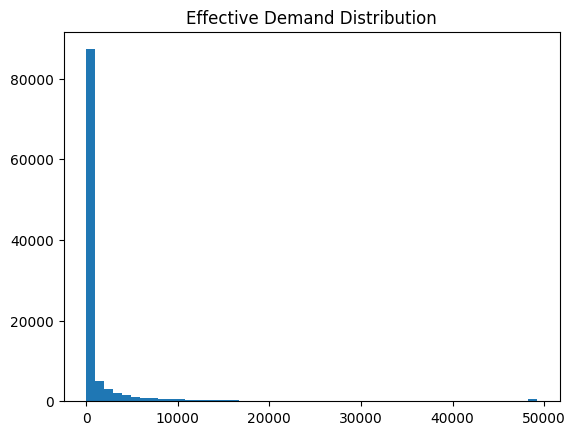

In [24]:
# Overall Distribution
plt.figure()
plt.hist(Data["Clean_Demand"], bins=50)
plt.title("Effective Demand Distribution")
plt.show()

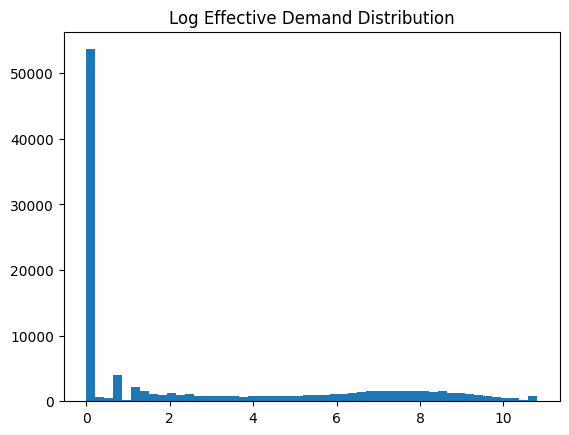

In [25]:
# Log Distribution
plt.figure()
plt.hist(np.log1p(Data["Clean_Demand"]), bins=50)
plt.title("Log Effective Demand Distribution")
plt.show()

In [26]:
print("Skewness:", Data["Clean_Demand"].skew())
print("Kurtosis:", Data["Clean_Demand"].kurt())

Skewness: 5.781436199857937
Kurtosis: 38.93687718410995


In [27]:
zero_ratio = (Data["Clean_Demand"]==0).mean()
print("Zero Demand Ratio:", zero_ratio)

Zero Demand Ratio: 0.49537565283536955


In [28]:
zero_ratio = (Data["Target"] == 0).mean()
print(zero_ratio)

0.5000046382619505


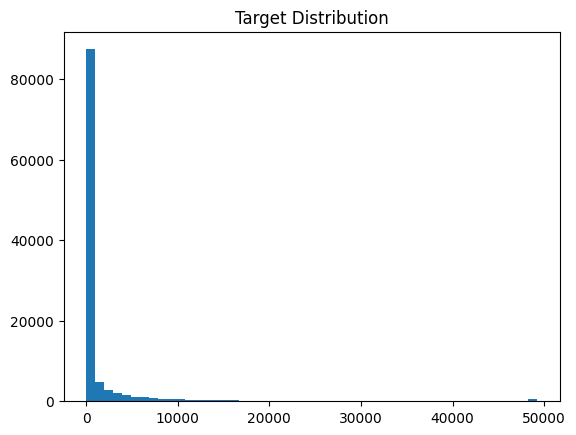

Target Skewness: 5.7820582685284725


In [29]:
plt.figure()
plt.hist(Data["Target"], bins=50)
plt.title("Target Distribution")
plt.show()

print("Target Skewness:", Data["Target"].skew())

In [30]:
q99 = Data["Clean_Demand"].quantile(0.99)

print("99th percentile:", q99)
print("Max Demand:", Data["Clean_Demand"].max())

99th percentile: 31654.046666666676
Max Demand: 49221.83999999988


In [31]:
sku_status = Data.groupby("ItemCode")["Clean_Demand"].agg(["mean", "std", "max", "min", "count"])
print(sku_status.describe())

               mean           std           max           min        count
count   2750.000000   2736.000000   2750.000000   2750.000000  2750.000000
mean    1394.121727    546.406564   2760.599354    435.531888    39.199636
std     4882.607468   1741.302831   8090.317566   2394.160726    12.186877
min        0.000000      0.000000      0.000000      0.000000     1.000000
25%        0.000000      0.000000      0.000000      0.000000    38.000000
50%        1.763931      2.423221     11.000000      0.000000    45.500000
75%      306.218085    210.491362   1034.250000      0.000000    47.000000
max    49221.840000  22416.329535  49221.840000  49221.840000    47.000000


# Modelling

### Core Config

In [32]:
TARGET_COL = "Target"

FEATURE_COLS = [
    "Lag1","Lag2","Lag3","Lag6","Lag12",
    "Rolling3M_Mean","Rolling6M_Mean","Rolling3M_Std",
    "Momentum",
    "Month_Sin","Month_Cos",
    "Inventory_Pressure",
    "Bonus_Flag","Supply_Constraint_Flag"
]

In [35]:
print("Min Target:", Data[TARGET_COL].min())
print("Any negative?", (Data[TARGET_COL] < 0).sum())
print("Any NaN?", Data[TARGET_COL].isna().sum())

Min Target: 0.0
Any negative? 0
Any NaN? 0


### Helper Functions

In [33]:
def sanitize(df):
    df = df.replace([np.inf, -np.inf], np.nan)
    return df.fillna(0)

def wmape(y_true, y_pred):
    denominator = np.sum(y_true)
    if denominator == 0:
        return 0
    return np.sum(np.abs(y_true - y_pred)) / denominator * 100

def forecast_bias(y_true, y_pred):
    return np.sum(y_pred - y_true) / np.sum(y_true) * 100

def evaluate_all_metrics(y_true, y_pred):
    return {
        "WMAPE": wmape(y_true, y_pred),
        "Bias": forecast_bias(y_true, y_pred),
        "MAE": mean_absolute_error(y_true, y_pred),
        "RMSE": np.sqrt(mean_squared_error(y_true, y_pred))
    }

In [38]:
print(Data[TARGET_COL].isna().sum())

0


### Cross Validation

In [ ]:
validation_years = [2022, 2023, 2024]
cv_results = []

for val_year in validation_years:

    train = Data[Data["Year"] < val_year]
    valid = Data[Data["Year"] == val_year]

    X_train = sanitize(train[FEATURE_COLS])
    y_train = train[TARGET_COL]

    X_valid = sanitize(valid[FEATURE_COLS])
    y_valid = valid[TARGET_COL]

    model = xgb.XGBRegressor(
        objective='reg:tweedie',
        tweedie_variance_power=1.4,
        learning_rate=0.02,
        max_depth=7,
        min_child_weight=6,
        reg_alpha=2.92,
        reg_lambda=2.13,
        subsample=0.90,
        colsample_bytree=0.86,
        n_estimators=1500,
        early_stopping_rounds=50,
        random_state=42
    )

    model.fit(
        X_train,
        y_train,
        eval_set=[(X_valid, y_valid)],
        verbose=False
    )

    preds = model.predict(X_valid)
    metrics = evaluate_all_metrics(y_valid.values, preds)
    metrics["Validation_Year"] = val_year

    cv_results.append(metrics)

cv_results = pd.DataFrame(cv_results)
print(cv_results)
print("\nAverage CV Performance:")
print(cv_results.mean())


Validation Year: 2022
Train min: nan
Valid min: 0.0
Train zeros: 0
Valid zeros: 5911

Validation Year: 2023
Train min: 0.0
Valid min: 0.0
Train zeros: 5911
Valid zeros: 11946

Validation Year: 2024
Train min: 0.0
Valid min: 0.0
Train zeros: 17857
Valid zeros: 15391
Empty DataFrame
Columns: []
Index: []

Average CV Performance:
Series([], dtype: float64)


### Tune

In [ ]:
train_data = Data[Data["Year"] <= 2023]
valid_data = Data[Data["Year"] == 2024]

X_train = sanitize(train_data[FEATURE_COLS])
y_train = train_data[TARGET_COL]

X_valid = sanitize(valid_data[FEATURE_COLS])
y_valid = valid_data[TARGET_COL]

In [ ]:
def objective(trial):

    params = {
        "objective": "reg:tweedie",
        "eval_metric": "rmse",
        "tweedie_variance_power": trial.suggest_float("tweedie_variance_power", 1.2, 1.55),
        "n_estimators": trial.suggest_int("n_estimators", 700, 1400),
        "learning_rate": trial.suggest_float("learning_rate", 0.02, 0.06),
        "max_depth": trial.suggest_int("max_depth", 4, 7),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 6),
        "subsample": trial.suggest_float("subsample", 0.75, 0.9),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.75, 0.9),
        "gamma": trial.suggest_float("gamma", 0, 0.3),
        "reg_lambda": trial.suggest_float("reg_lambda", 2, 12),
        "reg_alpha": trial.suggest_float("reg_alpha", 0, 3),
        "random_state": 42
    }

    model = xgb.XGBRegressor(**params)

    model.fit(
        X_train,
        y_train,
        eval_set=[(X_valid, y_valid)],
        early_stopping_rounds=50,
        verbose=False
    )

    preds = model.predict(X_valid)
    return wmape(y_valid.values, preds)

In [ ]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=40)

best_params = study.best_params

print("Best Params:", best_params)
print("Best Validation WMAPE:", study.best_value)

### FInal Production Train

In [ ]:
final_train = Data[Data["Year"] <= 2024]

X_final = sanitize(final_train[FEATURE_COLS])
y_final = final_train[TARGET_COL]

final_model = xgb.XGBRegressor(
    objective="reg:tweedie",
    eval_metric="rmse",
    random_state=42,
    **best_params
)

final_model.fit(X_final, y_final)

final_model.save_model("demand_model_prod.json")

print("Final production model trained and saved.")

# Visualize

In [ ]:
def plot_feature_importance(model):

    plt.figure(figsize=(8,6))
    xgb.plot_importance(model, importance_type="gain")
    plt.title("Feature Importance (Gain)")
    plt.tight_layout()
    plt.show()

In [ ]:
def plot_actual_vs_pred(y_test, preds):

    plt.figure(figsize=(6,6))
    plt.scatter(y_test, preds, alpha=0.3)
    plt.plot([y_test.min(), y_test.max()],
             [y_test.min(), y_test.max()],
             color="red")
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.title("Actual vs Predicted")
    plt.show()

In [ ]:
def plot_error_distribution(y_test, preds):

    errors = y_test - preds

    plt.figure(figsize=(7,5))
    plt.hist(errors, bins=50)
    plt.title("Forecast Error Distribution")
    plt.show()

In [ ]:
def plot_time_series(test_df, preds):

    df = test_df.copy()
    df["Prediction"] = preds

    df = df.sort_values(["Year", "Month_Number"])

    plt.figure(figsize=(12,5))
    plt.plot(df["Target"].values, label="Actual")
    plt.plot(df["Prediction"].values, label="Forecast")
    plt.legend()
    plt.title("Test Year Forecast vs Actual")
    plt.show()

In [ ]:
def walk_forward_validation(data, feature_cols, params):

    years = [2023, 2024]
    scores = []

    for split_year in years:

        train = data[data["Year"] <= split_year]
        test  = data[data["Year"] == split_year + 1]

        X_train = sanitize(train[feature_cols])
        y_train = train["Target"]

        X_test = sanitize(test[feature_cols])
        y_test = test["Target"]

        model = xgb.XGBRegressor(**params)
        model.fit(X_train, y_train, verbose=False)

        preds = clip_preds(model.predict(X_test))
        score = wmape(y_test, preds)

        scores.append(score)

    plt.figure(figsize=(6,4))
    plt.plot([2024, 2025], scores, marker="o")
    plt.title("Walk Forward WMAPE")
    plt.ylabel("WMAPE")
    plt.show()

    print("Average CV WMAPE:", np.mean(scores))